In [22]:
# TESTING WITH LATEST DATASET (00:00, 2, December, 2025) -> (00:00, 06, December, 2025)

In [23]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone

PROM_URL = "http://10.35.29.108:30900/api/v1/query_range"

# TIME RANGE (THAILAND)
TH = timezone(timedelta(hours=7))

start = datetime(2025, 12, 2, 0, 0, 0, tzinfo=TH)
end   = datetime(2025, 12, 6, 0, 0, 0, tzinfo=TH)

start_ts = start.timestamp()
end_ts = end.timestamp()

# NODES
nodes = {
    "109": "10.35.29.109:9100",
    "110": "10.35.29.110:9100"
}

# RAW PROMQL QUERIES
CPU_QUERY = 'node_cpu_seconds_total{instance="%s"}'
MEM_AVAIL_QUERY = 'node_memory_MemAvailable_bytes{instance="%s"}'
MEM_TOTAL_QUERY = 'node_memory_MemTotal_bytes{instance="%s"}'

RUNNING_QUERY = 'sum(kube_pod_status_phase{phase="Running"})'
PENDING_QUERY = 'sum(kube_pod_status_phase{phase="Pending"})'

# GENERIC QUERY FUNCTION
def prom_query(query):
    params = {
        "query": query,
        "start": start_ts,
        "end": end_ts,
        "step": "60s"
    }

    r = requests.get(PROM_URL, params=params).json()

    if "data" not in r or len(r["data"]["result"]) == 0:
        return pd.DataFrame()

    frames = []
    for result in r["data"]["result"]:

        df = pd.DataFrame(result["values"], columns=["timestamp", "value"])
        
        # Convert to Thailand time
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s", utc=True)
        df["timestamp"] = df["timestamp"].dt.tz_convert("Asia/Bangkok")

        df["value"] = df["value"].astype(float)

        # Attach metric labels
        for k, v in result.get("metric", {}).items():
            df[k] = v

        frames.append(df)

    return pd.concat(frames, ignore_index=True)

# QUERY RAW CPU + MEMORY
cpu_frames = []
mem_avail_frames = []
mem_total_frames = []

for node_id, inst in nodes.items():

    # CPU counters
    raw_cpu = prom_query(CPU_QUERY % inst)
    raw_cpu["node"] = node_id
    cpu_frames.append(raw_cpu)

    # Memory available
    raw_avail = prom_query(MEM_AVAIL_QUERY % inst)
    raw_avail = raw_avail.rename(columns={"value": "mem_avail"})
    raw_avail["node"] = node_id
    mem_avail_frames.append(raw_avail)

    # Memory total
    raw_total = prom_query(MEM_TOTAL_QUERY % inst)
    raw_total = raw_total.rename(columns={"value": "mem_total"})
    raw_total["node"] = node_id
    mem_total_frames.append(raw_total)


cpu_raw = pd.concat(cpu_frames)
mem_avail = pd.concat(mem_avail_frames)
mem_total = pd.concat(mem_total_frames)

# Running (cluster-wide)
running_raw = prom_query(RUNNING_QUERY).rename(columns={"value": "running_total"})

# Pending (cluster-wide)
pending_raw = prom_query(PENDING_QUERY).rename(columns={"value": "pending"})

# PIVOT CPU COUNTERS
cpu_pivot = cpu_raw.pivot_table(
    index="timestamp",
    columns=["node", "mode"],
    values="value"
)

cpu_pivot.columns = [
    f"cpu_{mode}_{node}"
    for (node, mode) in cpu_pivot.columns
]

cpu_pivot = cpu_pivot.reset_index()

# MERGE MEMORY + POD METRICS
df = cpu_pivot

# memory available
df = df.merge(
    mem_avail.pivot_table(index="timestamp", columns="node", values="mem_avail")
        .rename(columns=lambda x: f"mem_avail_{x}"),
    on="timestamp", how="left"
)

# memory total
df = df.merge(
    mem_total.pivot_table(index="timestamp", columns="node", values="mem_total")
        .rename(columns=lambda x: f"mem_total_{x}"),
    on="timestamp", how="left"
)

# running cluster-wide
df = df.merge(running_raw, on="timestamp", how="left")

# pending cluster-wide
df = df.merge(pending_raw, on="timestamp", how="left")

df = df.sort_values("timestamp")

df.to_csv("Dataset_Dec2_Dec6.csv", index=False)

# print("✔ DONE — Final dataset created:", df.shape)
# print(df.head())


In [25]:
import pandas as pd

# Load raw dataset
df = pd.read_csv("Dataset_Dec2_Dec6.csv")

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sort by time
df = df.sort_values("timestamp")

# Drop duplicate timestamps
df = df.drop_duplicates(subset=["timestamp"])

# Drop rows where ANY metric is missing
df = df.dropna()

# print("Cleaned dataset shape:", df.shape)
# df.head()


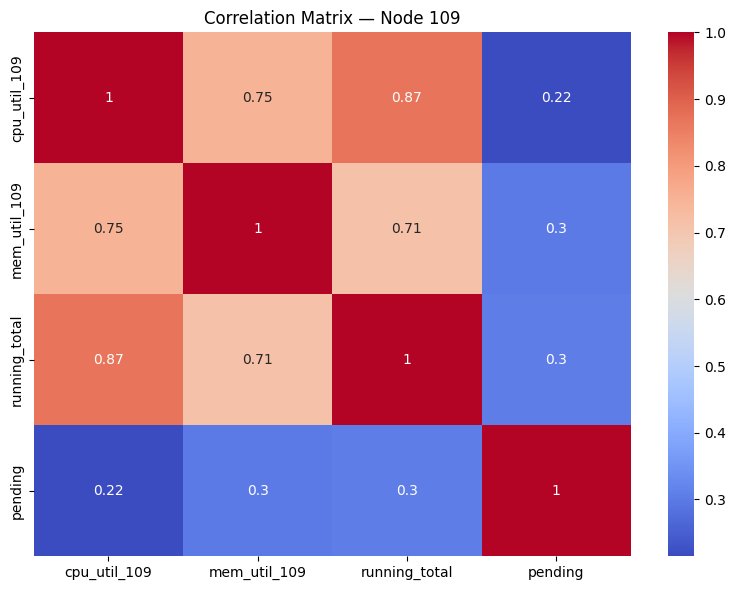

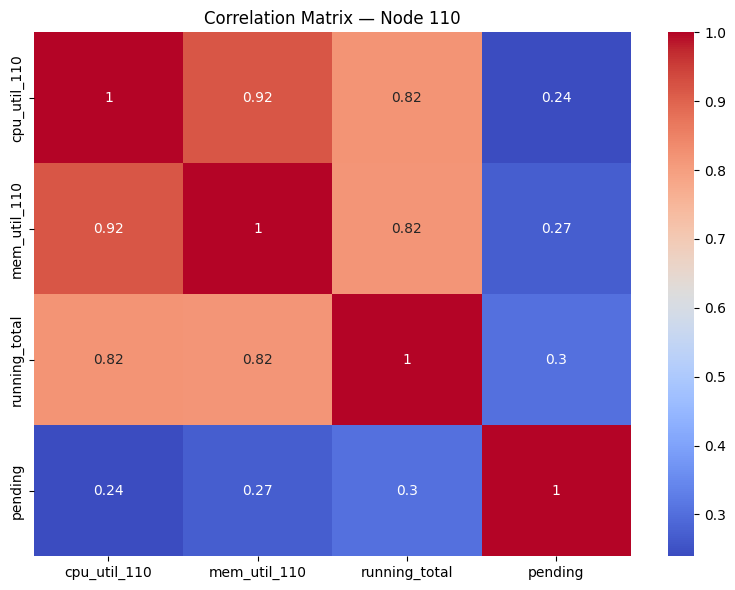

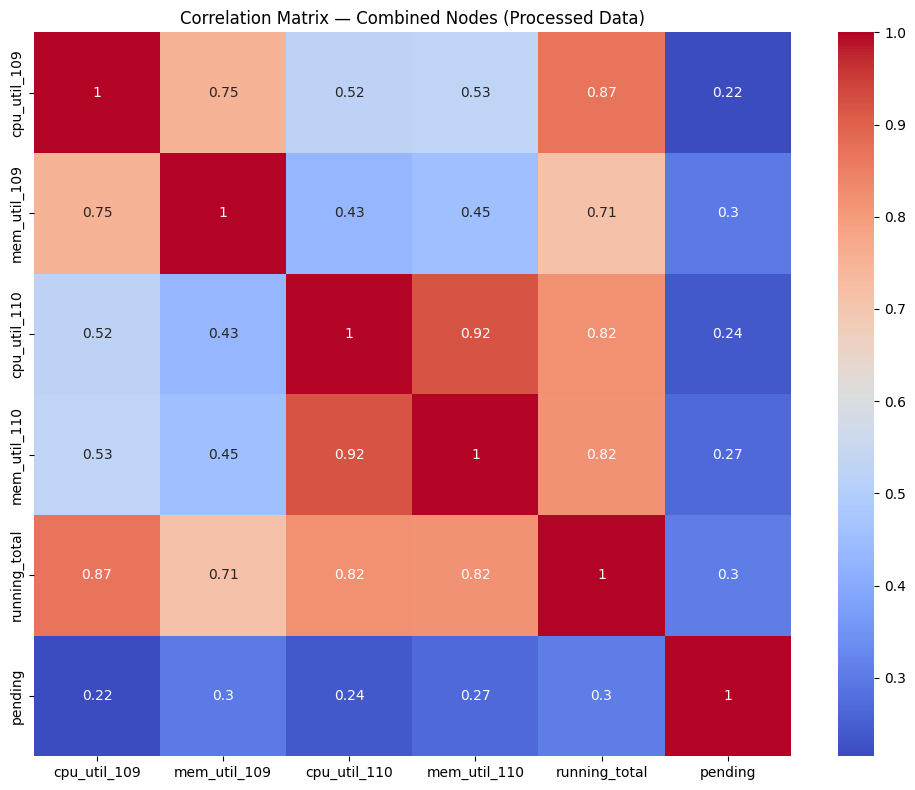

In [30]:
import pandas as pd

df = pd.read_csv("Dataset_Dec2_Dec6.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")
df = df.dropna()

nodes = ["109", "110"]
cpu_modes = ["idle", "user", "system", "iowait", "irq", "nice", "softirq", "steal"]

processed = df.copy()

# CPU Utilization Calculation
for node in nodes:
    # Total CPU seconds for this node
    processed[f"cpu_total_{node}"] = 0
    for mode in cpu_modes:
        col = f"cpu_{mode}_{node}"
        if col in processed.columns:
            processed[f"cpu_total_{node}"] += processed[col]

    # deltas
    processed[f"idle_delta_{node}"] = processed[f"cpu_idle_{node}"].diff()
    processed[f"total_delta_{node}"] = processed[f"cpu_total_{node}"].diff()

    # CPU utilization %
    processed[f"cpu_util_{node}"] = 1 - (
        processed[f"idle_delta_{node}"] / processed[f"total_delta_{node}"]
    )

# Memory Utilization Calculation
for node in nodes:
    processed[f"mem_util_{node}"] = 1 - (
        processed[f"mem_avail_{node}"] / processed[f"mem_total_{node}"]
    )

# drop NaN rows created by diff()
processed = processed.dropna()

# Keep only processed features for correlation
processed_features = processed[
    [
        "timestamp",
        "cpu_util_109", "mem_util_109",
        "cpu_util_110", "mem_util_110",
        "running_total",
        "pending",
    ]
]

processed_features.to_csv("Dataset_Processed.csv", index=False)

# print("Processed dataset saved. Shape:", processed_features.shape)
# processed_features.head()

import matplotlib.pyplot as plt
import seaborn as sns

node109 = processed_features[
    ["cpu_util_109", "mem_util_109", "running_total", "pending"]
]

plt.figure(figsize=(8,6))
sns.heatmap(node109.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix — Node 109")
plt.tight_layout()
plt.savefig("corr_node109.png", dpi=300)
plt.show()

node110 = processed_features[
    ["cpu_util_110", "mem_util_110", "running_total", "pending"]
]

plt.figure(figsize=(8,6))
sns.heatmap(node110.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix — Node 110")
plt.tight_layout()
plt.savefig("corr_node110.png", dpi=300)
plt.show()

overall = processed_features.drop(columns=["timestamp"])

plt.figure(figsize=(10,8))
sns.heatmap(overall.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix — Combined Nodes (Processed Data)")
plt.tight_layout()
plt.savefig("corr_all_nodes.png", dpi=300)
plt.show()


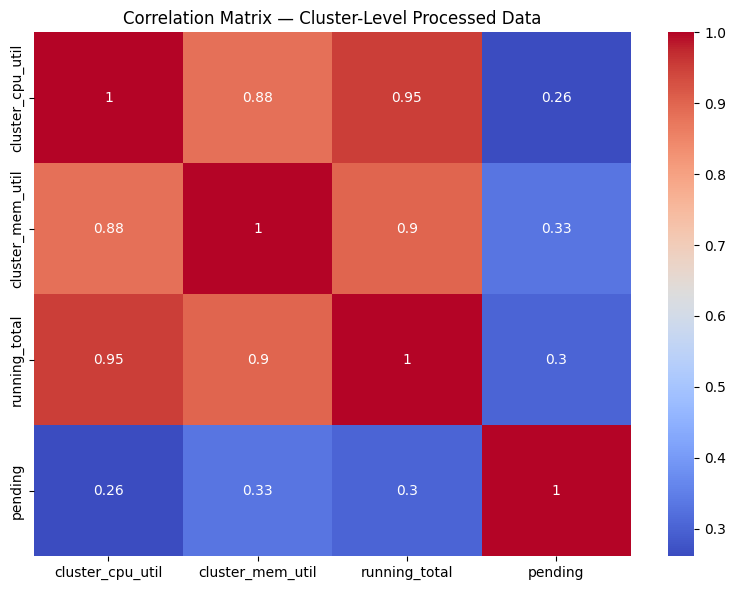

In [33]:
import pandas as pd

df = pd.read_csv("Dataset_Processed.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp")

# Compute cluster-level aggregated features
df["cluster_cpu_util"] = (df["cpu_util_109"] + df["cpu_util_110"]) / 2
df["cluster_mem_util"] = (df["mem_util_109"] + df["mem_util_110"]) / 2

cluster_df = df[
    [
        "timestamp",
        "cluster_cpu_util",
        "cluster_mem_util",
        "running_total",
        "pending"
    ]
]

cluster_df.to_csv("Dataset_Cluster_Level.csv", index=False)

# print("Cluster-level dataset created:", cluster_df.shape)
# cluster_df.head()

import matplotlib.pyplot as plt
import seaborn as sns

corr = cluster_df.drop(columns=["timestamp"]).corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix — Cluster-Level Processed Data")
plt.tight_layout()
plt.savefig("corr_cluster.png", dpi=300)
plt.show()


X shape: (4853, 20, 4)
y shape: (4853, 1)


/home/testuser/CPE-SENIOR-PROJECT-K8S/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,465 (306.50 KB)

 Trainable params: 78,465 (306.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
107/107 - 3s - 31ms/step - loss: 0.0890 - mae: 0.2344 - val_loss: 0.0314 - val_mae: 0.1282
Epoch 2/40
107/107 - 1s - 13ms/step - loss: 0.0320 - mae: 0.1350 - val_loss: 0.0292 - val_mae: 0.1319
Epoch 3/40
107/107 - 1s - 13ms/step - loss: 0.0274 - mae: 0.1228 - val_loss: 0.0259 - val_mae: 0.1096
Epoch 4/40
107/107 - 1s - 13ms/step - loss: 0.0255 - mae: 0.1179 - val_loss: 0.0257 - val_mae: 0.1140
Epoch 5/40
107/107 - 1s - 13ms/step - loss: 0.0247 - mae: 0.1152 - val_loss: 0.0221 - val_mae: 0.1153
Epoch 6/40
107/107 - 2s - 17ms/step - loss: 0.0240 - mae: 0.1143 - val_loss: 0.0232 - val_mae: 0.1071
Epoch 7/40
107/107 - 1s - 13ms/step - loss: 0.0233 - mae: 0.1130 - val_loss: 0.0233 - val_mae: 0.1108
Epoch 8/40
107/107 - 1s - 13ms/step - loss: 0.0225 - mae: 0.1093 - val_loss: 0.0220 - val_mae: 0.1005
Epoch 9/40
107/107 - 1s - 13ms/step - loss: 0.0213 - mae: 0.1073 - val_loss: 0.0181 - val_mae: 0.1006
Epoch 10/40
107/107 - 1s - 13ms/step - loss: 0.0208 - mae: 0.1041 - val_loss: 0.01

Saved model: LSTM_Cluster_Model.h5


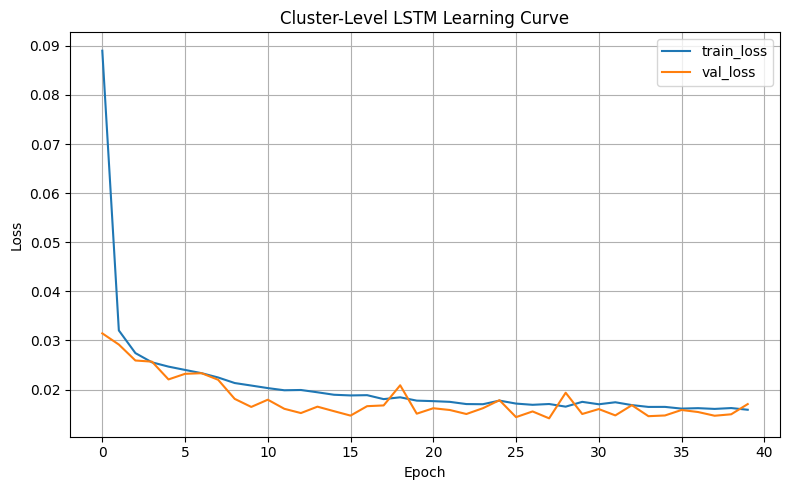

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Cluster CPU Prediction RMSE: 0.0671
Cluster CPU Prediction MAE: 0.0541


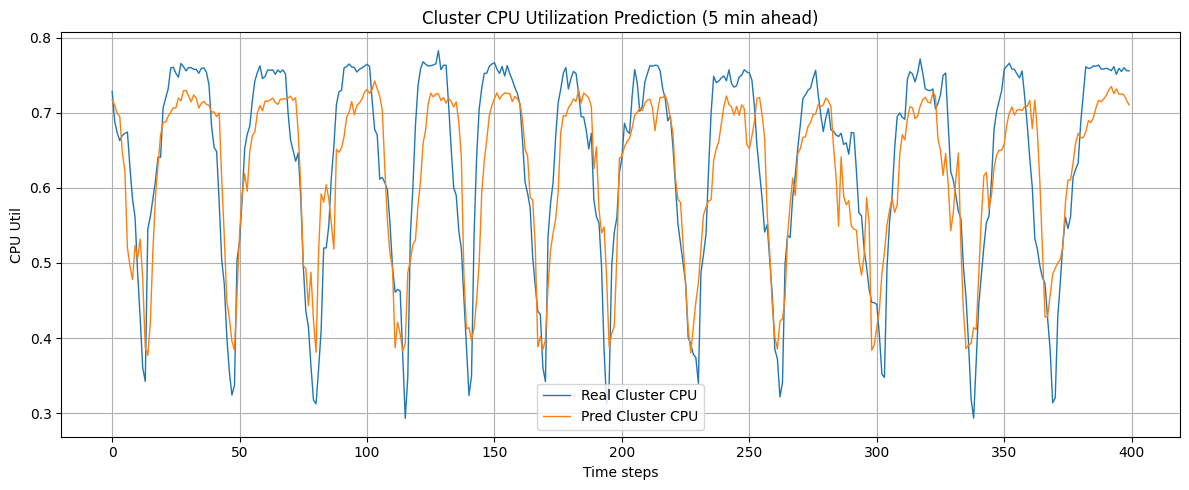

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os

# CONFIG
CSV_PATH = "Dataset_Cluster_Level.csv"
SEQ_LEN = 20
PRED_AHEAD = 5
EPOCHS = 40
BATCH_SIZE = 32
MODEL_OUT = "LSTM_Cluster_Model.h5"
FIG_DIR = "LSTM_Figures"
os.makedirs(FIG_DIR, exist_ok=True)

# LOAD DATA
df = pd.read_csv(CSV_PATH)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

features = ["cluster_cpu_util", "cluster_mem_util", "running_total", "pending"]
target = ["cluster_cpu_util"]

X_raw = df[features].values
y_raw = df[target].values

# SCALE
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# CREATE SEQUENCES
X, y = [], []
for i in range(len(X_scaled) - SEQ_LEN - PRED_AHEAD):
    X.append(X_scaled[i : i + SEQ_LEN])
    y.append(y_scaled[i + SEQ_LEN + PRED_AHEAD])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

# CHRONOLOGICAL SPLIT
n = len(X)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, X_val, X_test = X[:train_end], X[train_end:val_end], X[val_end:]
y_train, y_val, y_test = y[:train_end], y[train_end:val_end], y[val_end:]

# BUILD MODEL
model = Sequential([
    LSTM(128, input_shape=(SEQ_LEN, len(features)), return_sequences=False),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)  # single output: cluster_cpu_util
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

# TRAIN
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)

model.save(MODEL_OUT)
print("Saved model:", MODEL_OUT)

# LEARNING CURVE
plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Cluster-Level LSTM Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/Learning_Curve.png", dpi=300)
plt.show()

# PREDICT
y_pred_scaled = model.predict(X_test)
y_test_real = scaler_y.inverse_transform(y_test)
y_pred_real = scaler_y.inverse_transform(y_pred_scaled)

# METRICS
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
mae = mean_absolute_error(y_test_real, y_pred_real)

print(f"Cluster CPU Prediction RMSE: {rmse:.4f}")
print(f"Cluster CPU Prediction MAE: {mae:.4f}")

# PLOT PRED vs REAL
Nplot = min(400, len(y_test_real))

plt.figure(figsize=(12,5))
plt.plot(y_test_real[:Nplot], label="Real Cluster CPU", linewidth=1)
plt.plot(y_pred_real[:Nplot], label="Pred Cluster CPU", linewidth=1)
plt.title("Cluster CPU Utilization Prediction (5 min ahead)")
plt.xlabel("Time steps")
plt.ylabel("CPU Util")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/Pred_vs_Real.png", dpi=300)
plt.show()
